In [47]:
import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import seaborn
from sklearn.linear_model import Perceptron

Данные о качестве (вкусе) яблок. В основном предоставлены Американскими агрокультурными компаниями.

Загрузка данных

In [4]:
data = pandas.read_csv('data/apple_quality.csv')
data = data.drop(['A_id'], axis=1)
data = data.dropna()

Преобразование целевой переменной

In [5]:
le = LabelEncoder()
data['Quality'] = data['Quality'].apply(lambda x: 1 if x == 'good' else 0)
y = le.fit_transform(data['Quality'])
x = data.drop(['Quality'], axis=1)

Разделение данных

In [35]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y) # Выделяет 20% данных в качестве тестовых, 80% в качестве данных для обучения, сохраняет соотношение "хороших" и "плохих" яблок (за счет stratify=y)

Дерево решений с оптимизацией гиперпараметров

In [36]:
dt = DecisionTreeClassifier(random_state=42)
params_dt = {
    'max_depth': [3, 5, 7, None], # Максимальное количество "вопросов" для принятия решения
    'min_samples_split': [2, 5, 10] # Количество элементов в группе, после которого не нужно продолжать вопросы
}

grid_dt = GridSearchCV(dt, params_dt, cv=5, scoring='accuracy') # 1/5 данных (cv) будет выполнять роль тестовых, 4/5 обучение
grid_dt.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [3, 5, 7, None],
                         'min_samples_split': [2, 5, 10]},
             scoring='accuracy')

Визуализация кросс-валидации для дерева

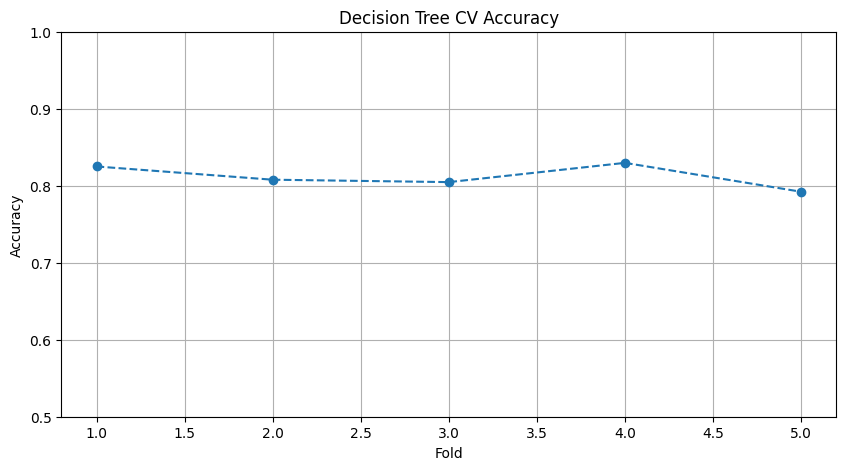

In [40]:
dt_scores = cross_val_score(grid_dt.best_estimator_, x_train, y_train, cv=5)
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), dt_scores, marker='o', linestyle='--')
plt.title('Decision Tree CV Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.grid()
plt.show()

Градиентный бустинг

In [42]:
gb = GradientBoostingClassifier(random_state=42, max_depth=7)
params_gb = {
    'n_estimators': [50, 100, 200], # Количество деревьев-экспертов
    'learning_rate': [0.01, 0.1, 0.5] # Резкость корректировки от эксперта
}

grid_gb = GridSearchCV(gb, params_gb, cv=5, scoring='accuracy')
grid_gb.fit(x_train, y_train) 

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=7, random_state=42),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

Визуализация кросс-валидации для бустинга

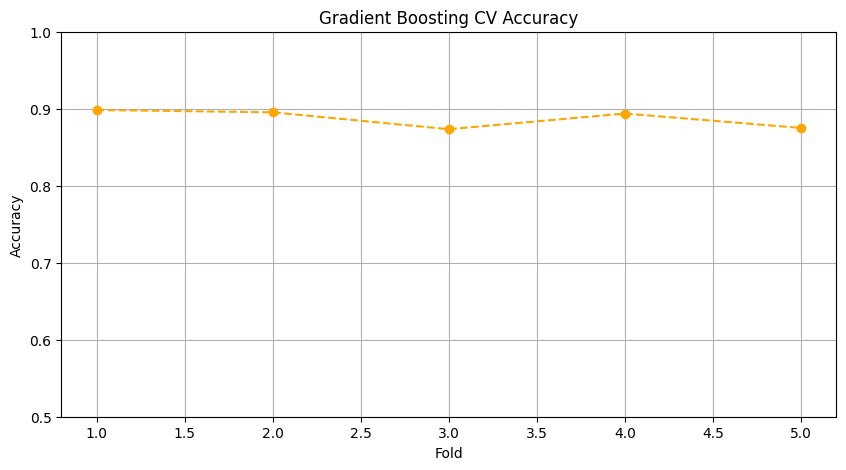

In [43]:
gb_scores = cross_val_score(grid_gb.best_estimator_, x_train, y_train, cv=5)
plt.figure(figsize=(10, 5))
plt.plot(range(1, 6), gb_scores, marker='o', color='orange', linestyle='--')
plt.title('Gradient Boosting CV Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim(0.5, 1.0)
plt.grid()
plt.show()

Оценка методов

Decision Tree:
Accuracy: 0.802

              precision    recall  f1-score   support

         bad       0.80      0.80      0.80       399
        good       0.80      0.81      0.80       401

    accuracy                           0.80       800
   macro avg       0.80      0.80      0.80       800
weighted avg       0.80      0.80      0.80       800

Gradient Boosting:
Accuracy: 0.884

              precision    recall  f1-score   support

         bad       0.90      0.86      0.88       399
        good       0.87      0.91      0.89       401

    accuracy                           0.88       800
   macro avg       0.88      0.88      0.88       800
weighted avg       0.88      0.88      0.88       800



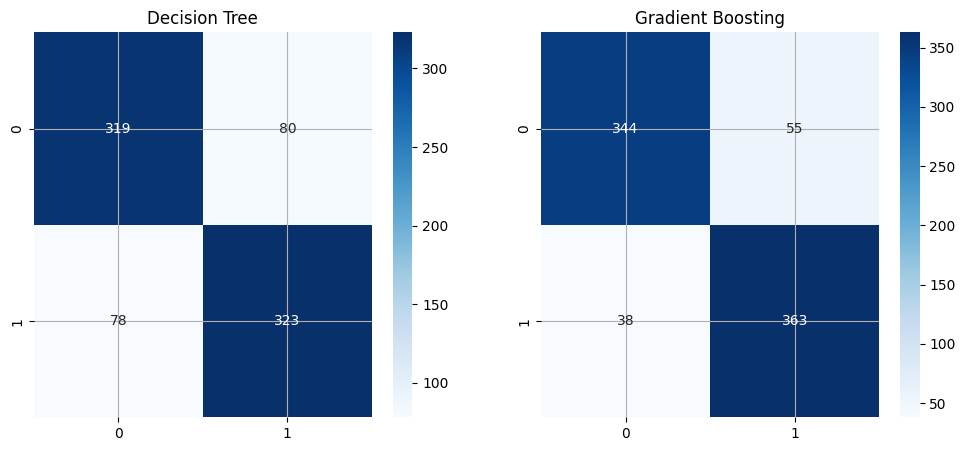

In [44]:
def evaluate_model(name, model, x_test, plot_config):
    plt.subplot(plot_config)
    
    y_pred = model.predict(x_test)

    print(name + ":")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.3f}\n")

    print(classification_report(y_test, y_pred, target_names=["bad", "good"]))

    plt.title(name)
    
    cm = confusion_matrix(y_test, y_pred)
    seaborn.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.grid()

plt.figure(figsize=(12, 5))

evaluate_model("Decision Tree", grid_dt.best_estimator_, x_test, 121)
evaluate_model("Gradient Boosting", grid_gb.best_estimator_, x_test, 122)

# precision - точность, сколько из определенных "плохими" яблок действительно плохие
# recall - полнота, сколько модель нашла действительно "плохих" яблок
# f1-score - общий показатель на основе precision и recall

Визуализация влияния гиперпараметров

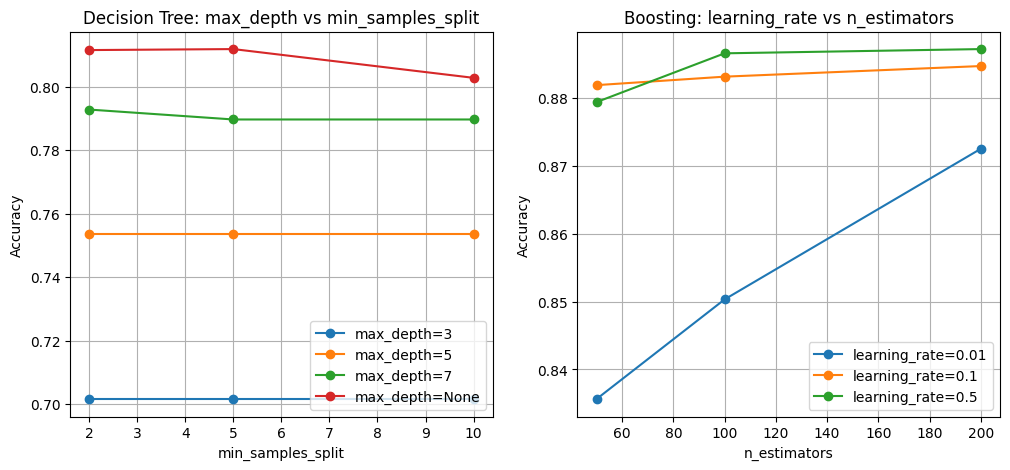

In [45]:
def params_plot(name, grid, params, line_param, x_param, n):
    results = pandas.DataFrame(grid.cv_results_)
    plt.subplot(n)
    for rate in params[line_param]:
        if rate is None:
            subset = results[results[f'param_{line_param}'].isna()]
        else:
            subset = results[results[f'param_{line_param}'] == rate]
        plt.plot(subset[f'param_{x_param}'], subset["mean_test_score"], 
                 label=f'{line_param}={rate}', marker='o')
    plt.title(f'{name}: {line_param} vs {x_param}')
    plt.xlabel(x_param)
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

plt.figure(figsize=(12, 5))

params_plot("Decision Tree", grid_dt, params_dt, "max_depth", "min_samples_split", 121)
params_plot("Boosting", grid_gb, params_gb, "learning_rate", "n_estimators", 122)